In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon as scipy_jsd
from scipy.optimize import minimize
from figaro.cosmology import CosmologicalParameters
from figaro.load import load_density
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from corner import corner
from numba import njit
from figaro import plot_settings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

## Function Definitions

In [3]:
# Mass distribution
from population_models.mass import plpeak

# dL distributions
# @njit
def dLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

In [4]:
def luminosity_distance_to_redshift(distance, H0):
    return np.array([CosmologicalParameters(H0[i]/100., 0.315, 0.685, -1., 0., 0.).Redshift(distance) for i in tqdm(range(len(H0)))])

## Source Frame Distributions
$$p(M, d_L) = p(M)p(d_L) = \mathrm{PLpeak}(M)*\mathrm{DLsq}(d_L)$$

In [5]:
m = np.linspace(20,200,1000)
dL = np.linspace(10,5000,100)

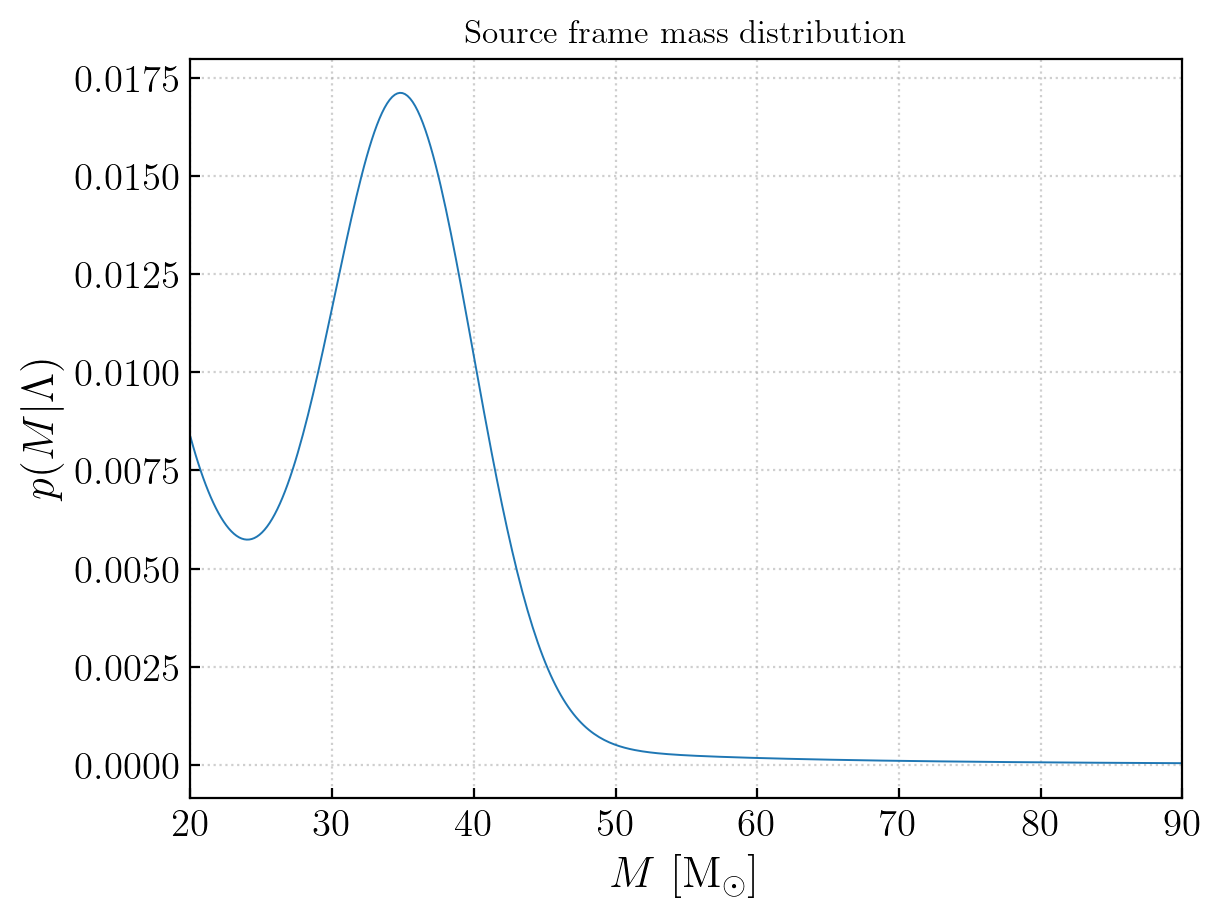

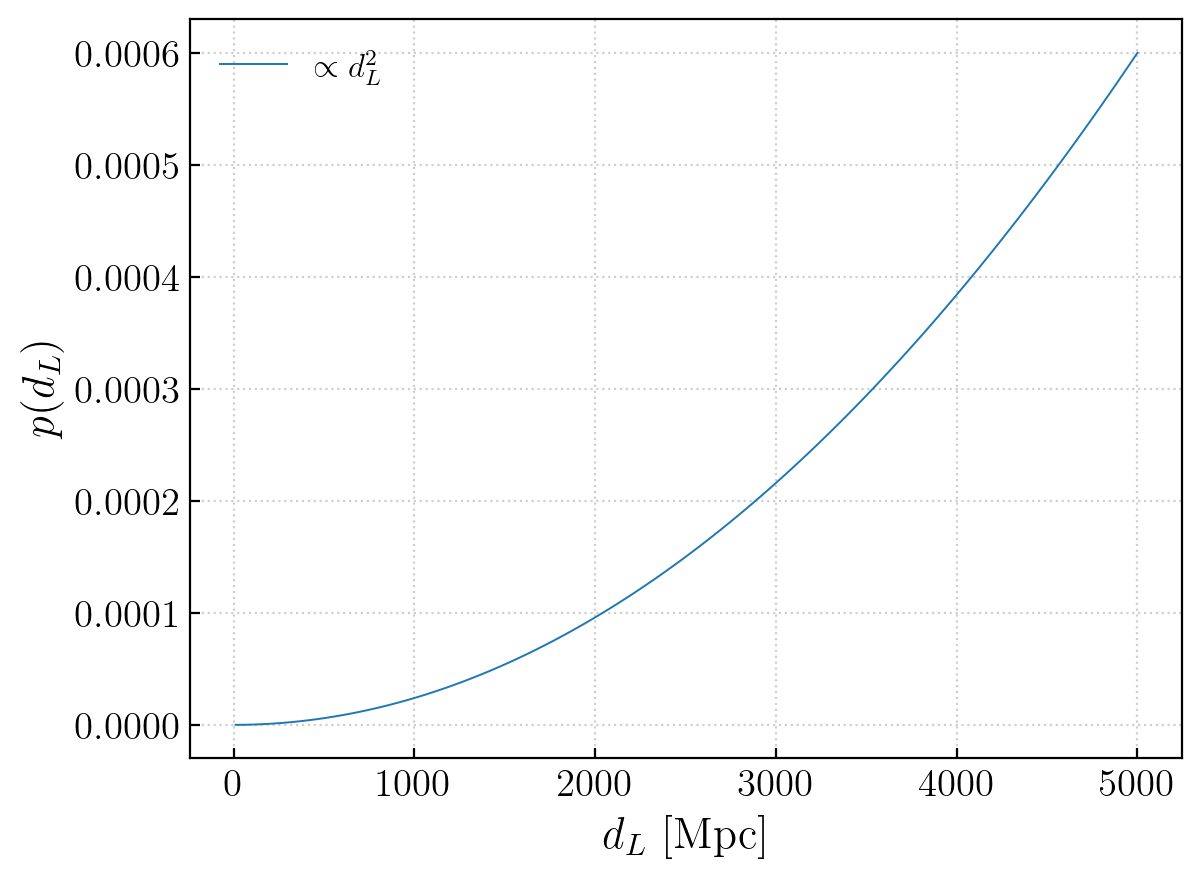

In [6]:
plt.plot(m, plpeak(m), label = "$\mathrm{PL+Peak}$")
plt.xlabel('$M\ [\mathrm{M}_\odot]$')
plt.ylabel('$p(M|\Lambda)$')
# plt.legend()
plt.xlim(20,90)
# plt.title("Source frame mass distribution")
# plt.savefig("./model_source_frame.pdf", bbox_inches='tight')
plt.show()
plt.plot(dL, dLsq(dL), label = "$\propto d_L^2$")
plt.xlabel('$d_L\ [\mathrm{Mpc}]$')
plt.ylabel('$p(d_L)$')
plt.legend()
plt.show()

## Detector Frame Distributions
$$p(M_z, d_L) = \frac{1}{1+z(d_L, \Omega)}\,\mathrm{PLpeak}\left(\frac{M_z}{1+z(d_L, \Omega)}\right)\,\mathrm{DLsq}(d_L)$$

In [7]:
# mz = np.linspace(20,200,1000)
# dL = np.linspace(10,5000,100)

# H0 = np.linspace(50,100,50)

# z = luminosity_distance_to_redshift(dL, H0)

# m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

mz, dL, H0, z, m = [np.load("./grid.npz")[i] for i in ["mz", "dL", "H0", "z", "m"]]

In [55]:
prop = np.einsum("ijk, j -> ijk", plpeak(m), dLsq(dL))

/users/chi-kit.ng/src/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))


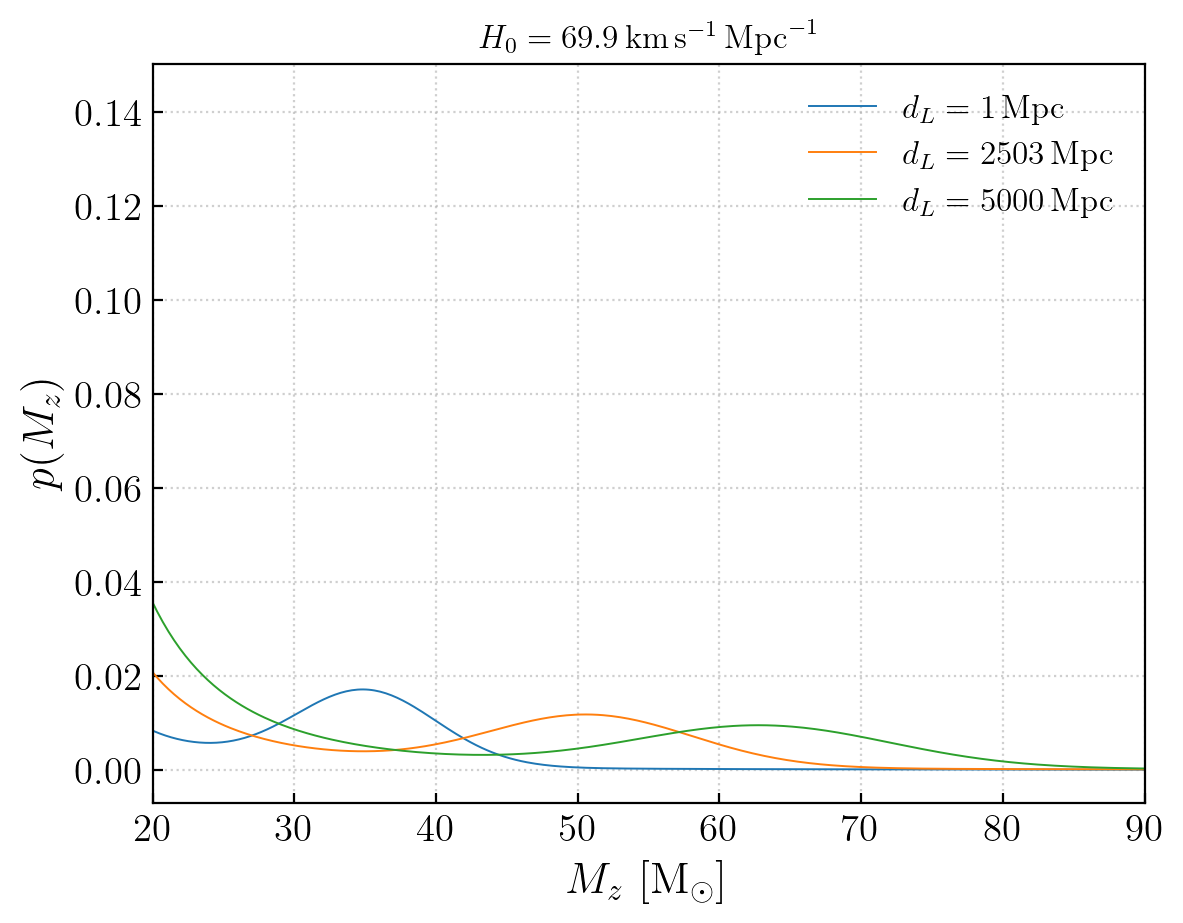

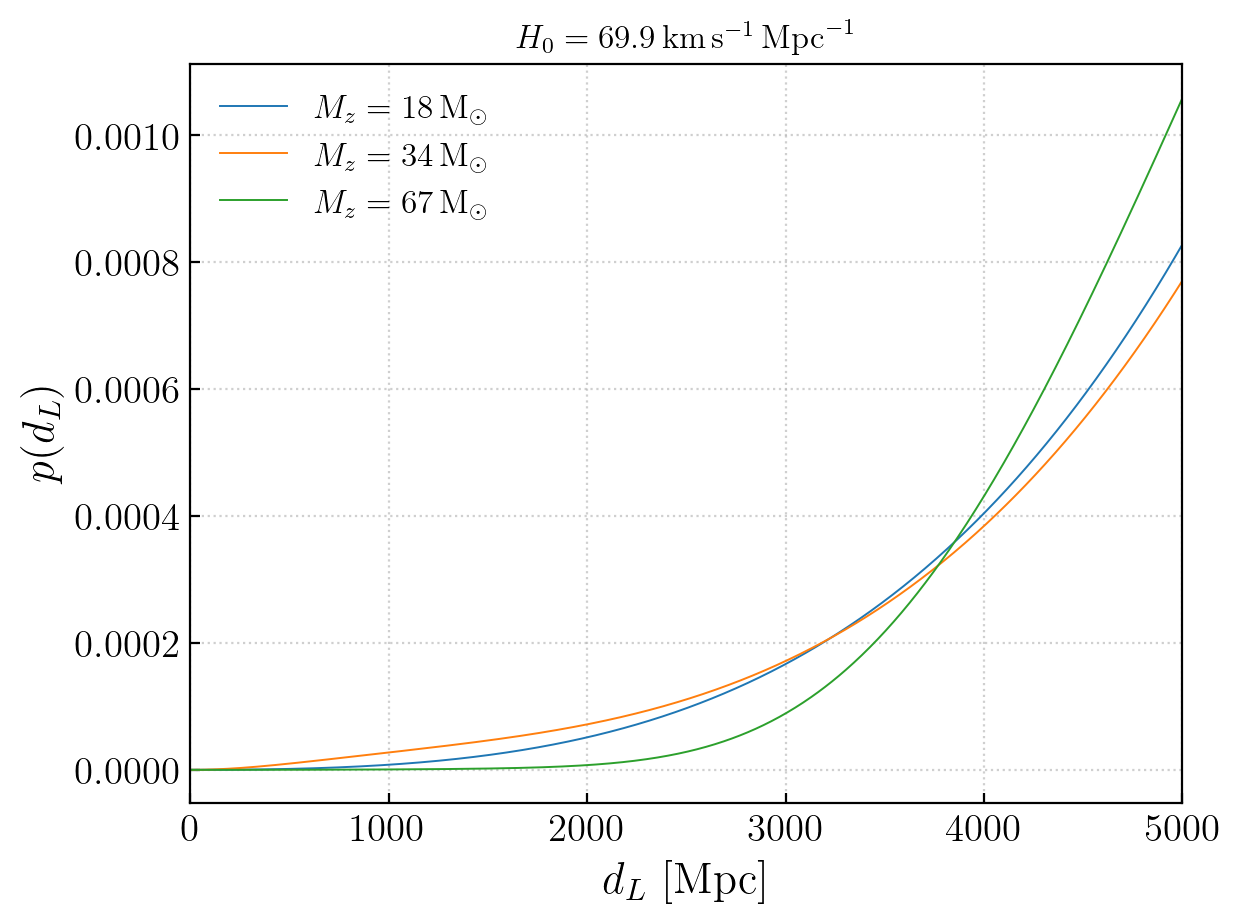

In [60]:
for i in [0, len(dL)//2, len(dL)-1]:
    p = prop[:,i,499]
    y = p / np.trapz(p, mz)
    plt.plot(mz, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.title("$H_0 = "+str(f'{H0[499]:.1f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(M_z)$')
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.xlim(20,90)
plt.legend()
plt.show()

for i in [len(mz)//12, len(mz)//6, len(mz)//3]:
    p = prop[i,:,499]
    y = p / np.trapz(p, dL[:])
    plt.plot(dL[:], y, label = "$M_z = "+str(f'{mz[i]:.0f}')+"\,\mathrm{M}_\odot$")
plt.title("$H_0 = "+str(f'{H0[499]:.1f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(d_L)$')
plt.xlabel('$d_L\ [\mathrm{Mpc}]$')
plt.xlim(0,5000)
plt.legend()
plt.show()

## Inference

In [12]:
# mz = np.linspace(20,200,1000)
# dL = np.linspace(10,5000,500)

# H0 = np.linspace(20,100,500)

# z = luminosity_distance_to_redshift(dL, H0)

# m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

# np.savez("./grid.npz", mz = mz, dL = dL, H0 = H0, z = z, m = m)

mz, dL, H0, z, m = [np.load("./grid.npz")[i] for i in ["mz", "dL", "H0", "z", "m"]]

In [6]:
p_mz = np.trapz(np.einsum("ijk, j -> ijk", plpeak(m), dLsq(dL)), dL, axis=1)
p_mz = p_mz/np.trapz(p_mz, mz, axis=0)

### Testing Plots

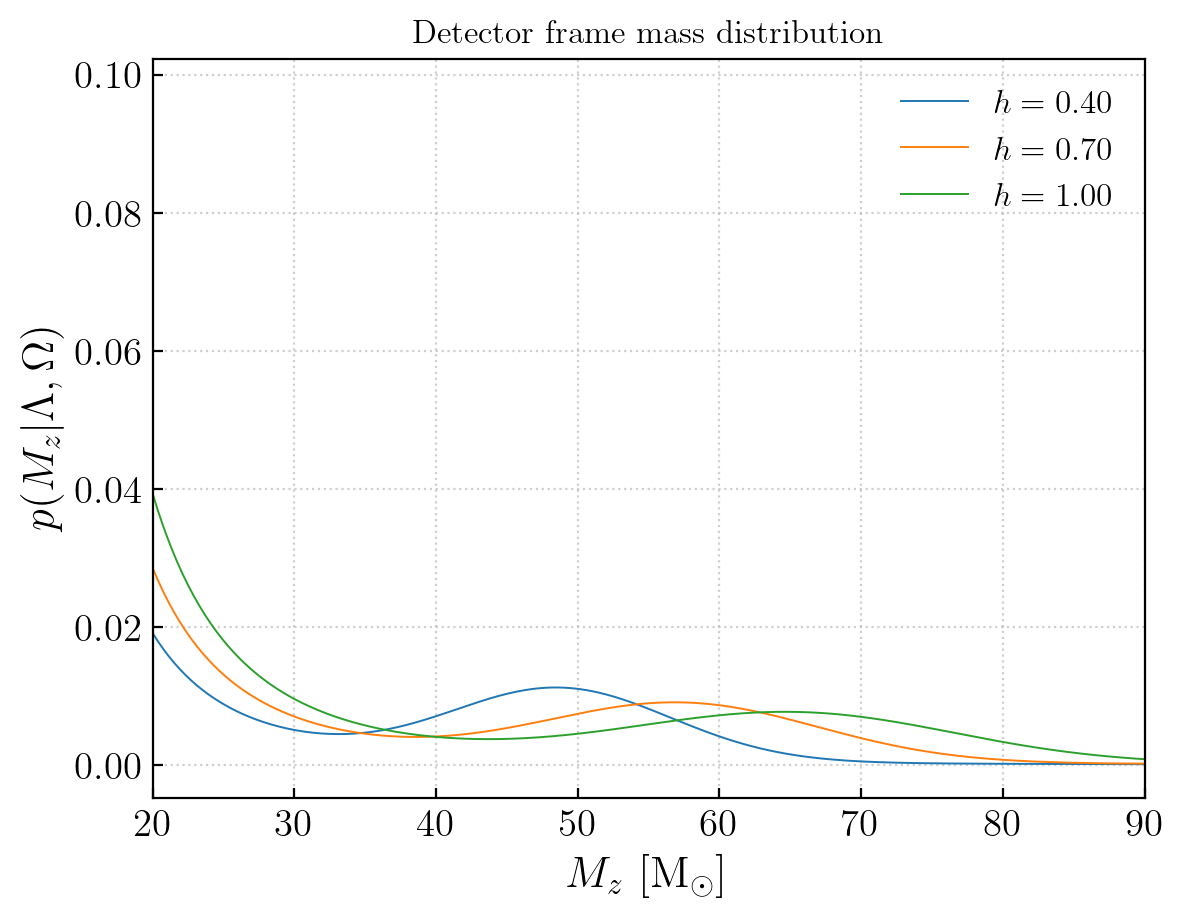

In [65]:
for i in [200,499,800]:
    p = p_mz[:,i]
    plt.plot(mz, p, label = "$h = "+str(f'{H0[i]/100:.2f}')+"$")
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.ylabel('$p(M_z|\Lambda,\Omega)$')
plt.xlim(20,90)
# plt.title("Detector frame mass distribution")
plt.legend()
# plt.savefig("./model_detector_frame.pdf", bbox_inches='tight')
plt.show()

### Estimating with Median Distribution Only

In [32]:
pdf_figaro = np.loadtxt("./prob_density.txt")

#### Squared Distance

In [33]:
error = np.sum(np.square(p_mz - np.full((len(H0), len(mz)), np.interp(mz, pdf_figaro[:,0], pdf_figaro[:,1])).T), axis=0)

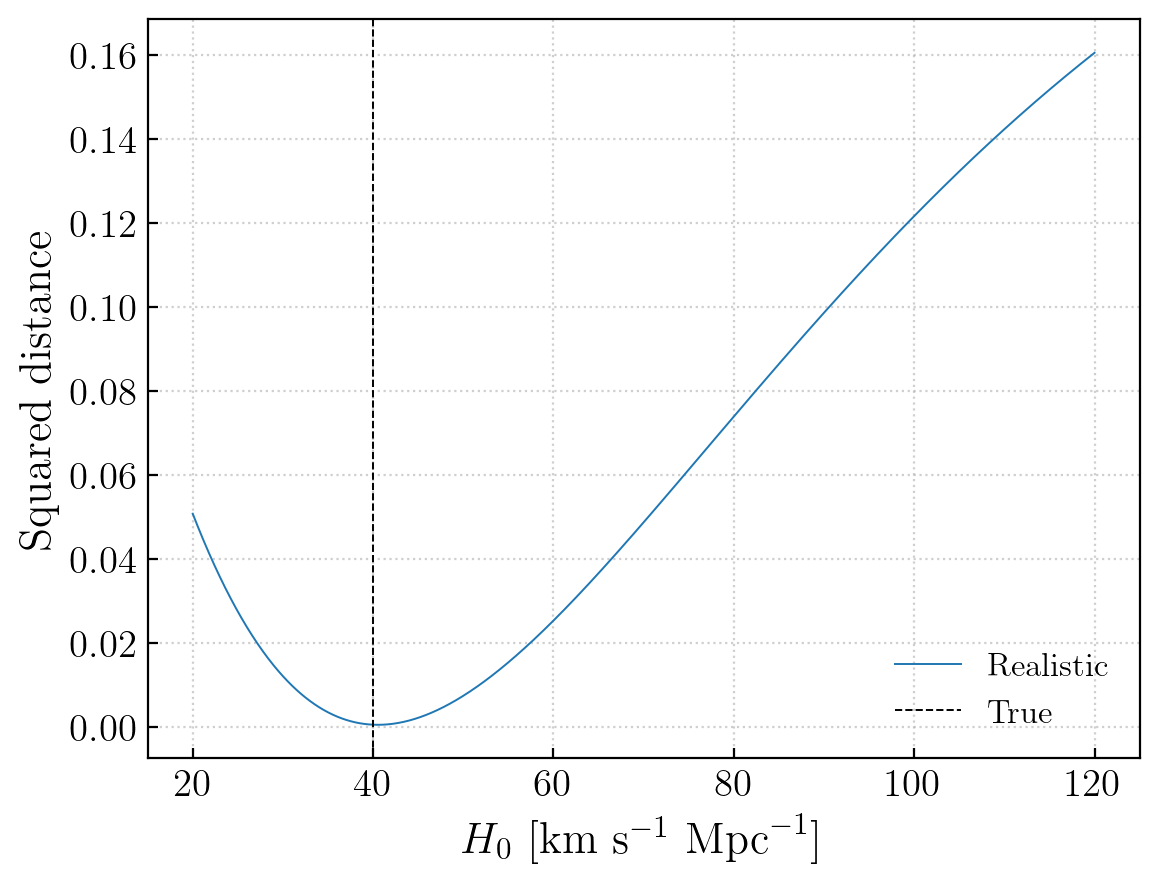

In [28]:
plt.plot(H0, error)
plt.xlabel('$H_0\ [\mathrm{km}\ \mathrm{s}^{-1}\ \mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{Squared\ distance}$')
plt.axvline(40, color = "black", linestyle = "--", label = "$\mathrm{True}$")
plt.legend()
plt.show()

In [29]:
H0[np.argmin(error)]

40.52052052052052

#### Jensen-Shannon Distance

In [34]:
jsd = scipy_jsd(p_mz, np.full((len(H0), len(mz)), np.interp(mz, pdf_figaro[:,0], pdf_figaro[:,1])).T)

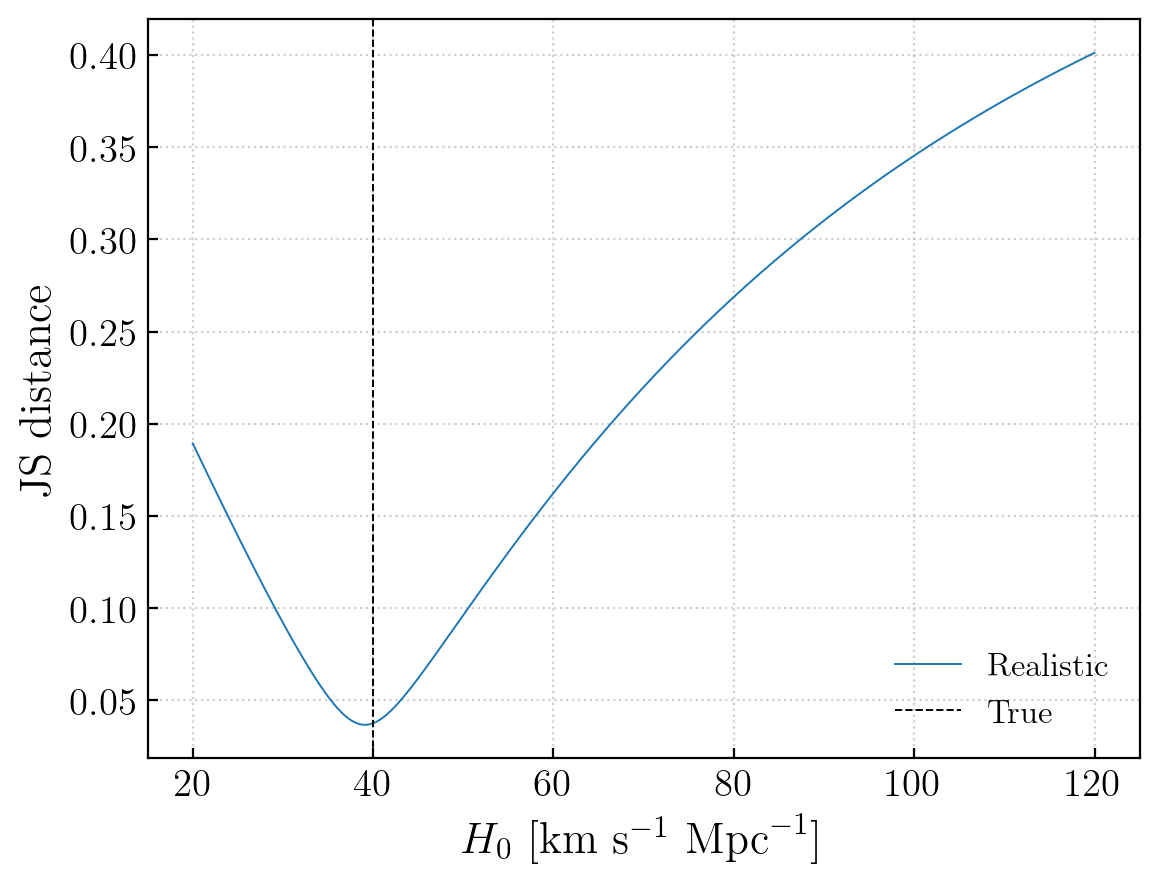

In [35]:
plt.plot(H0, jsd)
plt.xlabel('$H_0\ [\mathrm{km}\ \mathrm{s}^{-1}\ \mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{JS\ distance}$')
plt.axvline(40, color = "black", linestyle = "--", label = "$\mathrm{True}$")
plt.legend()
plt.show()

In [20]:
H0_min = H0[np.argmin(jsd)]
H0_min

### Estimating $H_0$ with All Distributions (Jensen-Shannon Distance)

In [23]:
pdf_figaro = load_density("test/draws_samples.json")

In [24]:
def selection_function(x):
    p = x/100
    p[x>100]=1
    return p

In [25]:
pdf_figaro = np.array([pdf_figaro[i].pdf(mz)/selection_function(mz) for i in range(len(pdf_figaro))])

In [26]:
jsd = np.array([scipy_jsd(p_mz, np.full((len(H0), len(mz)), pdf_figaro[i]).T) for i in tqdm(range(len(pdf_figaro)))])

100%|██████████| 1000/1000 [00:07<00:00, 140.52it/s]


#### Max Range in the Percentile Bands

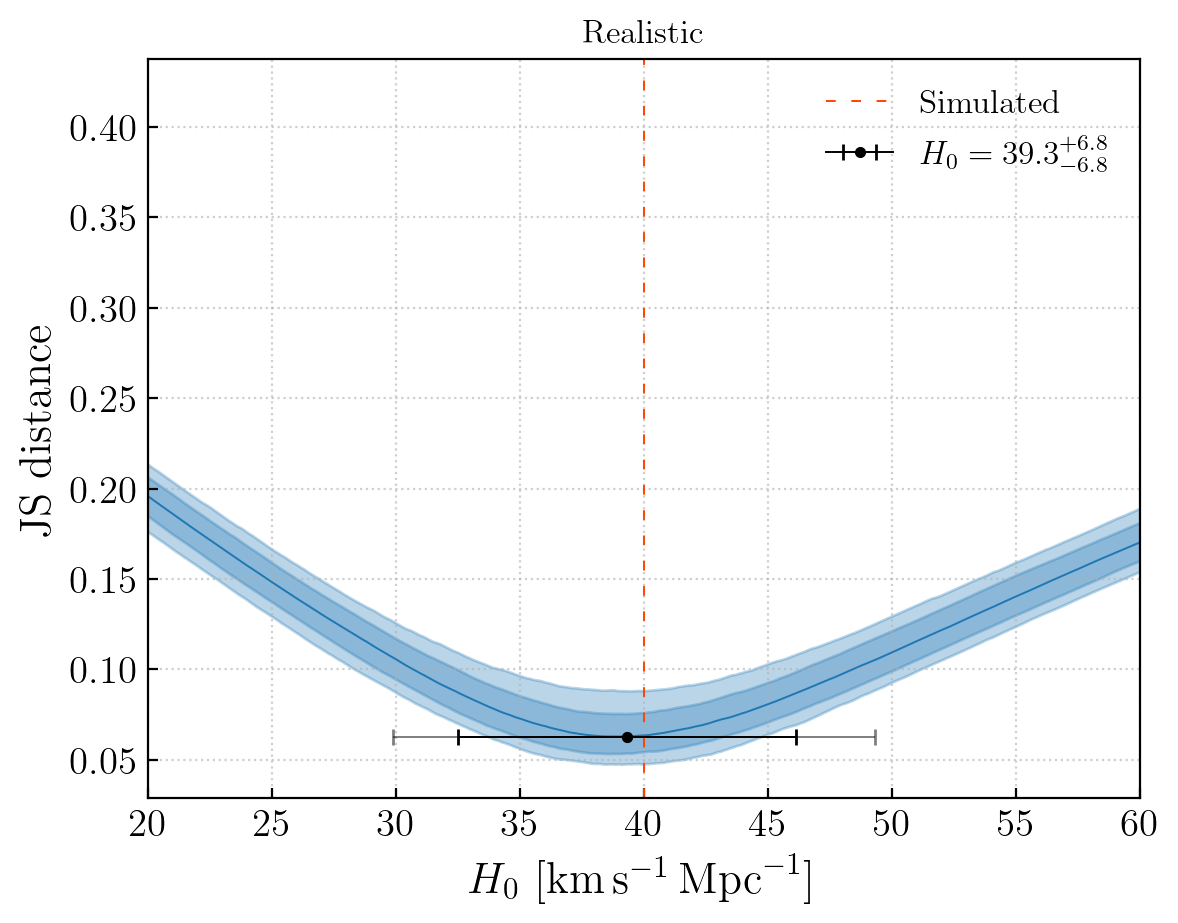

In [25]:
percs = np.percentile(jsd, [5, 16, 50, 84, 95], axis=0)
plt.axvline(40, lw = 0.7, ls = '--', dashes=(5, 8), c = 'orangered', label = '$\\mathrm{Simulated}$')
plt.fill_between(H0, percs[0], percs[-1], alpha=0.3, color='C0')
plt.fill_between(H0, percs[1], percs[-2], alpha=0.3, color='C0')
plt.plot(H0, percs[2], color='C0')

# Point Estimate
H0_min = H0[np.argmin(percs[2])]

# 90% CI
jsd_upper_bound = percs[4].min()
jsd_upper_bound_index = np.argmin(percs[4])
bool_array = percs[0]>jsd_upper_bound
lower_bound = np.where((bool_array)[0:jsd_upper_bound_index])[0][-1]
upper_bound = np.where((bool_array)[jsd_upper_bound_index:])[0][0] + jsd_upper_bound_index
plt.errorbar(H0_min, percs[2].min(), xerr=[[H0_min-H0[lower_bound]], [H0[upper_bound]-H0_min]],
             color='k', capsize=3, marker='o', markersize=3, alpha = 0.5)
# 68% CI
jsd_upper_bound = percs[3].min()
jsd_upper_bound_index = np.argmin(percs[3])
bool_array = percs[1]>jsd_upper_bound
lower_bound = np.where((bool_array)[0:jsd_upper_bound_index])[0][-2]
upper_bound = np.where((bool_array)[jsd_upper_bound_index:])[0][1] + jsd_upper_bound_index
plt.errorbar(H0_min, percs[2].min(), xerr=[[H0_min-H0[lower_bound]], [H0[upper_bound]-H0_min]],
             color='k', capsize=3, marker='o', markersize=3,
             label = '$H_0 = '+str(f'{H0_min:.1f}')+'^{+'+str(f'{H0[upper_bound]-H0_min:.1f}')+'}_{-'+str(f'{H0_min-H0[lower_bound]:.1f}')+'}$')

plt.xlim(20,60)
plt.xlabel('$H_0\ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{JS\ distance}$')
plt.legend(loc = 0)
plt.show()

#### Calculating $H_0$ for each DPGMM Draw

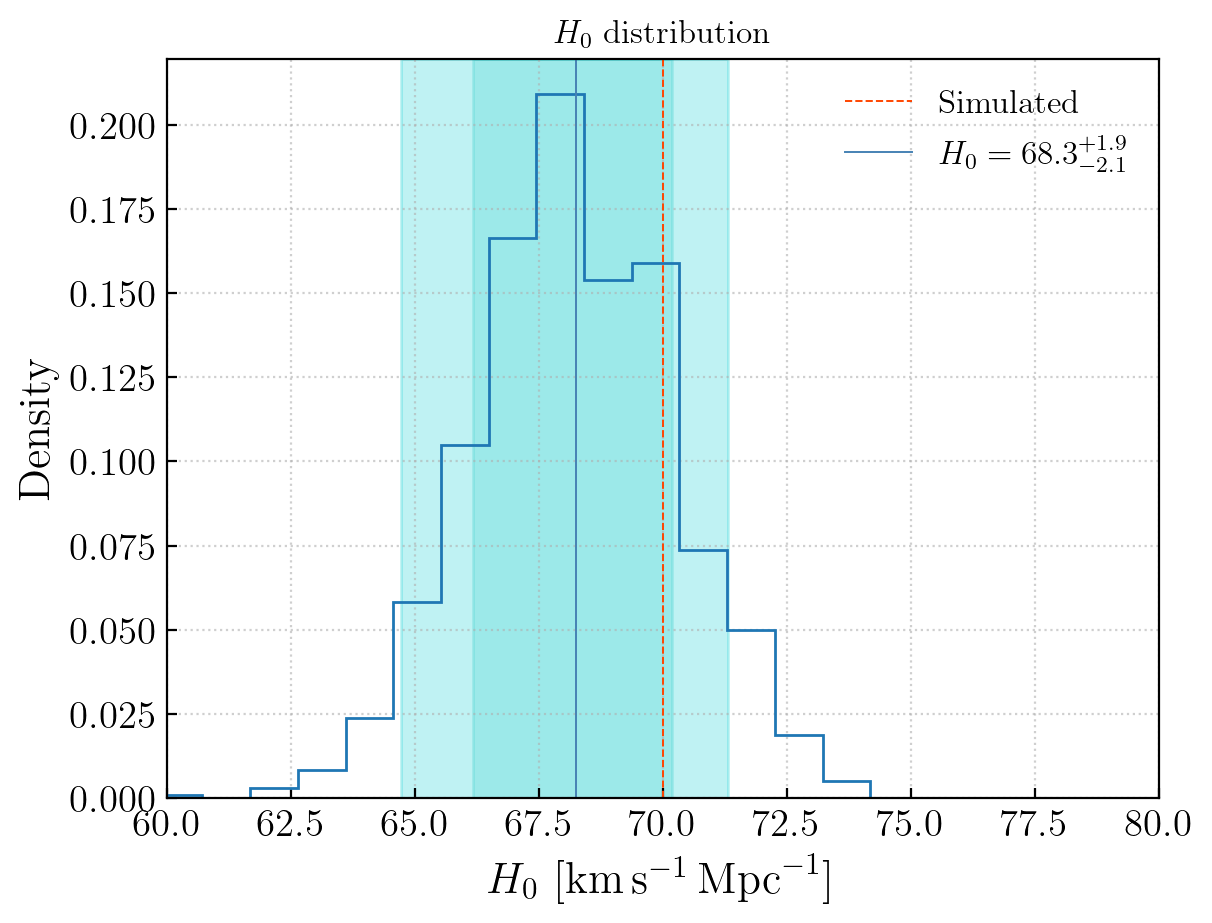

In [27]:
H0_sample = H0[np.argmin(jsd, axis=1)]
percs = np.percentile(H0_sample, [5, 16, 50, 84, 95])
plt.hist(H0_sample, density = True, histtype = 'step', bins = 25)
plt.axvline(70, lw = 0.7, ls = '--', c = 'orangered', label = '$\\mathrm{Simulated}$')
plt.axvline(percs[2], c = 'steelblue', lw=0.7,
            label = '$H_0 = '+str(f'{percs[2]:.1f}')+'^{+'+str(f'{percs[3]-percs[2]:.1f}')+'}_{-'+str(f'{percs[2]-percs[1]:.1f}')+'}$')
plt.axvspan(percs[1], percs[3], alpha=0.25, color='mediumturquoise')
plt.axvspan(percs[0], percs[4], alpha=0.25, color='darkturquoise')
plt.xlabel('$H_0\ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{Density}$')
plt.legend(loc = 0)
plt.xlim(60,80)
plt.title("$H_0$ distribution")
# plt.savefig("./H0_distribution.pdf", bbox_inches='tight')
plt.show()

In [28]:
np.sum(H0_sample<=70)/len(H0_sample)

0.812